# Inference

The purpose of this notebook is to allow for evaluation/sampling with a trained NF model

## Setup

In [1]:
# Import packages
import torch
import numpy as np
import normflows as nf

import uproot as up

from matplotlib import pyplot as plot
import math
from tqdm import tqdm
from util import PVect, theta_func, r_func,get_layer, create_layer_map
from IPython.display import clear_output
import time
from concurrent.futures import ThreadPoolExecutor

Using device cuda:0


In [2]:
from reco import process_data, create_dataloader, prepare_data_for_nn, create_dataloader

In [3]:
# Get device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import os
def checkdir(path):
    if not os.path.exists(path): 
        os.makedirs(path)

### Load data from .pt file (created by preprocess.py)

## Neural Spline Flow

In [5]:
# Define flows
run_num = 4
run_num_str = str(run_num)

K = 1

latent_size = 1
hidden_units = 100
hidden_layers = 6
context_size = 3
num_context = 3
K_str = str(K)
batch_size= 2000
hidden_units_str = str(hidden_units)
hidden_layers_str = str(hidden_layers)
batch_size_str = str(batch_size)

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows)

# Move model on GPU if available
model = model.to(device)


In [6]:
import datetime
# if(slurm):
#     pref = "slurm/"
# else:
pref = ""
x = datetime.datetime.now()
today = x.strftime("%B_%d")
model_date = "July_22"
# today = "July_22"
# model_path = "models/context_3/" + today + "/"
# checkdir(model_path)
model_path = pref + "models/" + model_date + "/"
checkdir(model_path)

samples_path = pref + "data/samples/" + today + "/"
checkdir(samples_path)

test_data_path = pref + "data/test/" + today + "/"
checkdir(test_data_path)

test_dist_path = pref + "plots/test_distributions/" + today + "/"
checkdir(test_dist_path)

In [7]:
model.load(model_path + "run_" + run_num_str + "_" + str(num_context)+ "context_" +K_str +  "flows_" + hidden_layers_str+"hl_" + hidden_units_str+"hu_" + batch_size_str+"bs.pth")

### Evaluation

In [8]:
model = model.to(device)

In [16]:
#old path:
# up_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/mu/variation_10kevents_file_11.edm4hep.root:events"
'''muons'''
# up_path = f"/cwork/rck32/eic/work_eic/root_files/July_25/sector_scint/run_1_mu_5GeV_theta_vary_10kevents.edm4hep.root:events"
'''pions'''
up_path = f"/cwork/rck32/eic/work_eic/root_files/July_25/sector_scint/run_1_pi_5GeV_theta_vary_1kevents.edm4hep.root:events"

# up_path = f"/cwork/rck32/eic/work_eic/root_files/July_23/pi_5GeV_full_theta_sector_scint_100events.edm4hep.root:events"
data = process_data(up_path)

In [17]:
features, metadata = prepare_data_for_nn(data)
print("Features shape:", features.shape)
print("Metadata shape:", metadata.shape)

# Create DataLoader
batch_size = 1000000
dataloader = create_dataloader(features, metadata, batch_size)

len of events: 1000
Features shape: (24385546, 4)
Metadata shape: (24385546, 3)
(24385546, 4)


### Resampling inference with dataloader

In [11]:

# min_time = 0
# samples = torch.empty(features.shape[0],device = device)
# it = 0
# begin_time = time.time()
# for batch_features, batch_metadata in dataloader:
#     begin = batch_size * it
#     end = batch_size * (it + 1)
#     # Initialize a mask for valid samples
#     batch_features = batch_features.to(device)
#     valid_samples = torch.zeros(batch_features.shape[0], dtype=torch.bool,device = device)
#     batch_samples = torch.empty(batch_features.shape[0],device = device)
    
#     while not valid_samples.all():
#         # Generate samples for the invalid positions
#         new_samples = model.sample(num_samples=(~valid_samples).sum(), context=batch_features[~valid_samples])[0].squeeze(1)
        
#         # Update the samples and the valid_samples mask
#         batch_samples[~valid_samples] = new_samples
#         valid_samples = batch_samples >= min_time
    
#     samples[begin:end] = batch_samples
#     it += 1
#     if(it >= 0):
#         break
# end_time = time.time()
# samples_cpu = samples.cpu()

### No resampling

In [34]:
min_time = 0
samples = torch.empty(features.shape[0],device = device)
hit_times = torch.empty(features.shape[0],device = device)
layer_idxs = torch.empty(features.shape[0],device = device)
it = 0
begin_time = time.time()
with torch.no_grad():
    for batch_features, batch_metadata in dataloader:
#         clear_output(wait=True)
#         print(f"Starting batch #{it} out of {74920939 // batch_size} | {(time.time() - begin_time)} seconds elapsed")
        # Initialize a mask for valid samples
        context_features = batch_features[:, :3].clone().to(device)
        context_features[:, 1] *= 180 / 3.14159
        samples[batch_size * it:(batch_size * it) + len(batch_features)] = (model.sample(num_samples=context_features.shape[0], context=context_features)[0]).squeeze(1)
        samples[it*batch_size:(batch_size * it) + len(batch_features)].add_(batch_features[:, 3].to(device))
    #     samples[begin:end] = (model.sample(num_samples=context_features.shape[0], context=context_features)[0].cpu().detach()).squeeze(1)
        hit_times[batch_size * it:(batch_size * it) + len(batch_features)] = batch_features[:,3]
        layer_idxs[batch_size * it:(batch_size * it) + len(batch_features)] = batch_metadata[:,2]
#         del batch_features
#         it += 1
        break
end_time = time.time()

samples_cpu = samples.cpu().detach()
hit_times_cpu = hit_times.cpu().detach()
layer_idxs_cpu = layer_idxs.cpu().detach()

In [28]:
# delta_t = 1209
delta_t = end_time - begin_time

In [29]:
print(f"Sampling {(batch_size * it) + len(batch_features)} times took {(delta_t)} seconds\n rate: {((batch_size * it) + len(batch_features)) / (delta_t)} samples/second")

Sampling 1000000 times took 11.135261058807373 seconds
 rate: 89804.80966892604 samples/second



on gpu - 3500 samples/second with no resampling w/20k batch size

on cpu - 1400 samples/second no resampling w/20k batch size 

on cpu - 1136 samples/second no resampling w/10k batch size

on cpu - 2179 samples/second no resampling w/40k batch size

on gpu - 212 samples/second w resampling

on gpu - 3200 samples/second no resampling w/40k batch size

on gpu - 12000 samples/second no resampling w/80k batch size

on gpu - 5000 samples/second no resampling w/40k batch size

on gpu - 40k samples/second no resampling w/500k batch size

on gpu - 40k samples/second no resampling w/700k batch size

on gpu - 2 flow model - 73k samples/second no resampling w/500k batch size

on gpu - 2 flow model - 74k samples/second no resampling w/1m batch size

on gpu - 1 flow model - 100k samples/second w 2m batch size (july 16 run 1)

##### Below is the histogram of samples (no adding)

In [7]:
# torch.save(samples,"data/samples/July_15/Data/run_5_6_flows_4hl_100hu_4000_bs.pt")
# torch.save(eval_test_data,"data/test/July_12/run_1_8_flows_4hl_100hu_5000_bs.pt")

# samples = torch.load("data/samples/July_11/run_5_6_flows_4hl_100hu_5000_bs.pt")
# eval_test_data = torch.load("data/test/July_11/run_5_6_flows_4hl_100hu_5000_bs.pt")

## Load in and compare to real data

In [9]:
import numpy as np
import os
import math
from concurrent.futures import ThreadPoolExecutor
from typing import Union, List

time_branch_name = "HcalBarrelHits.time"
hit_x_branch_name = "HcalBarrelHits.position.x"
file_dir = f"/cwork/rck32/eic/work_eic/root_files/July_25/sector_sensor/pi/"
file_names = [name for name in os.listdir(file_dir) if not os.path.isdir(os.path.join(file_dir, name))]
tree_ext = ":events"

layer_map, super_layer_map = create_layer_map()

def get_super_layer(x_pos, s_map, s_dis):
    rel_dist = x_pos - (s_map[0] - (s_dis / 2))
    if rel_dist < -2:
        return -1
    return int(np.floor(rel_dist / s_dis))

def get_internal_layer(x_pos, super_layer_idx, s_map):
    rel_dist = x_pos - s_map[super_layer_idx]
    return int((math.copysign(1, rel_dist) + 1) / 2)

def get_layer(x_pos, s_map=super_layer_map):
    s_dis = s_map[1] - s_map[0]
    super_layer_idx = get_super_layer(x_pos, s_map, s_dis)
    internal_layer_idx = get_internal_layer(x_pos, super_layer_idx, s_map)
    return int(super_layer_idx * 2 + internal_layer_idx)

def process_file(file_name):
    with up.open(os.path.join(file_dir, file_name) + tree_ext) as file:
        times = file[time_branch_name].array(library="np")
        x_hits = file[hit_x_branch_name].array(library="np")
    return times, x_hits

def vectorized_get_layer(x_pos_array):
    return np.array([get_layer(x) for x in x_pos_array])

# Use ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor() as executor:
    results = list(executor.map(process_file, file_names))

# Combine results
event_times = np.concatenate([r[0] for r in results])
event_x_hit = np.concatenate([r[1] for r in results])

# Process events
truth_times = []
for times, x_hits in zip(event_times, event_x_hit):
    mask = times < 50
    if np.any(mask):  # Only process if there are hits passing the time condition
        try:
            layer_idx = vectorized_get_layer(x_hits[mask])
            truth_times.extend(np.column_stack((times[mask], layer_idx)))
        except Exception as e:
            print(f"Error processing event: {e}")
            print(f"x_hits[mask]: {x_hits[mask]}")
            continue

truth_times = np.array(truth_times)

print(f"Processed {len(truth_times)} hits")
print(f"Shape of truth_times: {truth_times.shape}")

Processed 3047025 hits
Shape of truth_times: (3047025, 2)


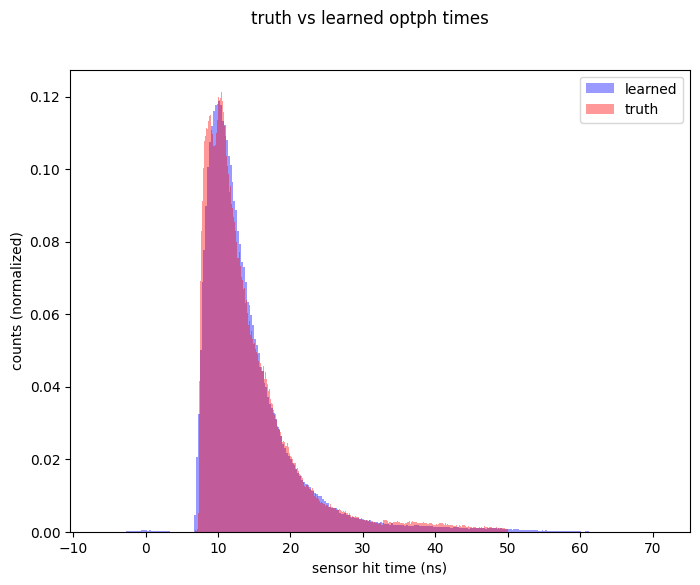

In [23]:
comp_fig, comp_axs = plot.subplots(1,1,figsize = (8,6))
comp_fig.suptitle("truth vs learned optph times")
comp_axs.hist(samples_cpu[:500000],bins = 300,density = True,color = "blue", alpha = 0.4,label = "learned")
# comp_axs.set_title("learned photon hit times")
comp_axs.set_xlabel("sensor hit time (ns)")
comp_axs.set_ylabel("counts (normalized)")
comp_axs.hist(truth_times[:500000][:,0],bins = 300,density = True, color = "red", alpha = 0.4,label = "truth");
comp_axs.legend()

In [24]:
comp_fig.savefig("plots/truth_comp/pi_july_25_run_1_full_theta.jpeg")

In [45]:
samples_short = samples_cpu[:500000]
layer_idxs_short = layer_idxs_cpu[:500000]
hit_times_short = hit_times_cpu[:500000]

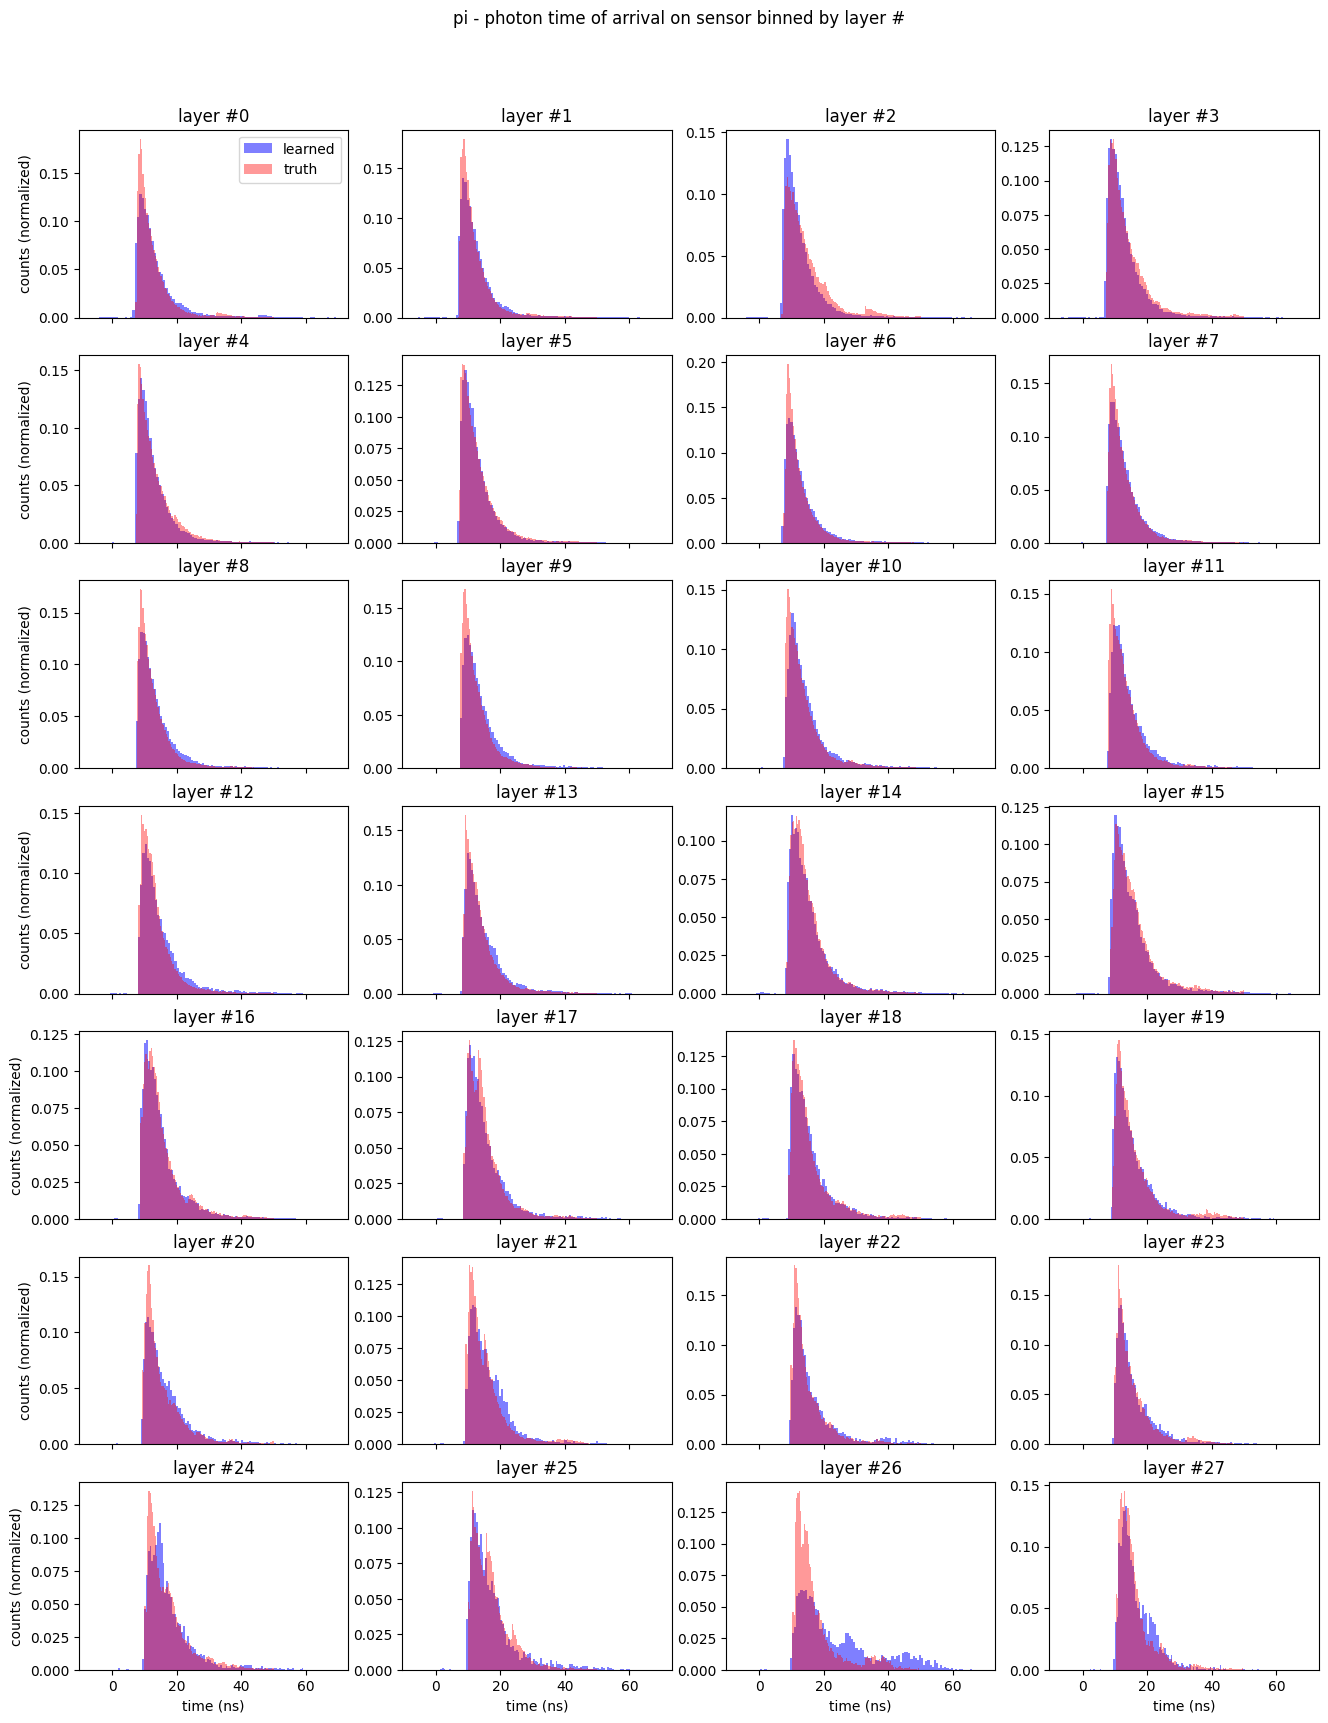

In [46]:
import matplotlib.ticker as plticker

layer_fig, layer_axs = plot.subplots(7,4,figsize=(16,20),sharex=True)
for i in range(7):
    for j in range(4):
        curr_layer = i * 4 + j
        curr_samples = samples_short[layer_idxs_short == curr_layer]#select hits in ith layer
        curr_hit_times = hit_times_short[layer_idxs_short == curr_layer]#select hits in ith layer
        curr_truth = truth_times[truth_times[:,1] == curr_layer][:,0]
        layer_fig.suptitle("pi - photon time of arrival on sensor binned by layer #",y = 0.94)
        layer_axs[i][j].hist(curr_samples,density = True, bins = 100,color = "blue",alpha = 0.5,label = "learned")
        layer_axs[i][j].hist(curr_truth,density = True, bins = 100, color = "red",alpha = 0.4,label = "truth")
        layer_axs[i][j].set_title(f"layer #{curr_layer}")
        if(i == 0 and j == 0):
            layer_axs[i][j].legend()
        if(i == 6):
            layer_axs[i][j].set_xlabel(f"time (ns)")
        if(j == 0):
            layer_axs[i][j].set_ylabel(f"counts (normalized)")

In [47]:
layer_fig.savefig("plots/truth_comp/july_25_pi_run_1_layer_binning.jpeg")